## Person Instance Segmentation with Swin Transformer

[Korean](01_garbage.ko-KR.ipynb) \| [English](01_garbage.en-US.ipynb) \| Copyright (c) 2023 [Jihoon Lucas Kim](https://github.com/kimnamu)

<a href="https://colab.research.google.com/github/kimnamu/cvnets/blob/master/demo/classfication/01_garbage.ko-KR.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

이 notebook은 Custom Dataset으로 Image Instance Segmentation 모델을 학습하는 과정을 다루고 있습니다.

reference
- [MMDetection](https://github.com/open-mmlab/mmdetection)
- https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_InstanceSeg_Tutorial.ipynb
- https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb

## Process - Inference

- COCO 데이터셋에서 사전 학습된 Mask R-CNN 모델을 로드하여 인퍼런스하는 주피터 노트북 예제를 작성하겠습니다.


- 0. 필요한 라이브러리 설치
- 1. 필요한 패키지 import
- 2. 사전 학습된 모델 다운로드
- 3. Config 파일 설정
- 4. Config 객체 생성
- 5. 모델 초기화 및 가중치 로드
- 6. 이미지 파일 준비
- 7. 인퍼런스 실행 및 결과 시각화

### 0. 필요한 라이브러리 설치

- MMDetection의 [Install Guide](https://github.com/open-mmlab/mmdetection/blob/master/docs/en/get_started.md/#Installation)를 따라 라이브러리를 설치합니다.
- mmcv version check : [here](https://download.openmmlab.com/mmcv/dist/index.html)
- pytorch version check : [here](https://pytorch.org/get-started/previous-versions/)

In [ ]:
# install pytorch
!pip install torch==1.7.0+cu110 torchvision==0.8.1+cu110 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Step 0. Install MMCV using MIM.
!pip install openmim
!mim install mmcv-full

# Step 1. Install MMDetection.
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection
!pip install -v -e .

### 1. 필요한 패키지 import

In [1]:
import mmcv
from mmcv import Config
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

/home/ohouse-recomm/miniconda3/envs/torch17/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ohouse-recomm/miniconda3/envs/torch17/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


### 2. 사전 학습된 모델 다운로드

In [2]:
!wget https://download.openmmlab.com/mmdetection/v2.0/swin/mask_rcnn_swin-t-p4-w7_fpn_1x_coco/mask_rcnn_swin-t-p4-w7_fpn_1x_coco_20210902_120937-9d6b7cfa.pth

--2023-04-09 00:38:17--  https://download.openmmlab.com/mmdetection/v2.0/swin/mask_rcnn_swin-t-p4-w7_fpn_1x_coco/mask_rcnn_swin-t-p4-w7_fpn_1x_coco_20210902_120937-9d6b7cfa.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 39.125.80.217, 39.125.80.213, 39.125.80.210, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|39.125.80.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191461353 (183M) [application/octet-stream]
Saving to: ‘mask_rcnn_swin-t-p4-w7_fpn_1x_coco_20210902_120937-9d6b7cfa.pth’

mask_rcnn_swin-t-p4 100%[===================>] 182.59M  11.4MB/s    in 15s     

2023-04-09 00:38:33 (12.1 MB/s) - ‘mask_rcnn_swin-t-p4-w7_fpn_1x_coco_20210902_120937-9d6b7cfa.pth’ saved [191461353/191461353]



### 3. Config 파일 설정

In [3]:
import mmcv

# Choose to use a config and initialize the detector
config = 'configs/swin/mask_rcnn_swin-t-p4-w7_fpn_1x_coco.py'

# Setup a checkpoint file to load
checkpoint = 'mask_rcnn_swin-t-p4-w7_fpn_1x_coco_20210902_120937-9d6b7cfa.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)

# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

### 4. Config 객체 생성

In [4]:
from mmcv.runner import load_checkpoint
from mmdet.models import build_detector

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

load checkpoint from local path: mask_rcnn_swin-t-p4-w7_fpn_1x_coco_20210902_120937-9d6b7cfa.pth


MaskRCNN(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (adap_padding): AdaptivePadding()
      (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (drop_after_pos): Dropout(p=0.0, inplace=False)
    (stages): ModuleList(
      (0): SwinBlockSequence(
        (blocks): ModuleList(
          (0): SwinBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): ShiftWindowMSA(
              (w_msa): WindowMSA(
                (qkv): Linear(in_features=96, out_features=288, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=96, out_features=96, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop): DropPath()
            )
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_aff

### 5. 모델 초기화 및 가중치 로드

In [5]:
from mmdet.apis import inference_detector
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

/home/ohouse-recomm/lucas/models/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


### 6. 인퍼런스 실행 및 결과 시각화
이제 주피터 노트북에서 실행하면, COCO 데이터셋에서 사전 학습된 Mask R-CNN 모델을 로드하여 이미지에 대한 인스턴스 세그멘테이션 결과를 얻을 수 있습니다. 결과는 주피터 노트북에서 시각화됩니다.

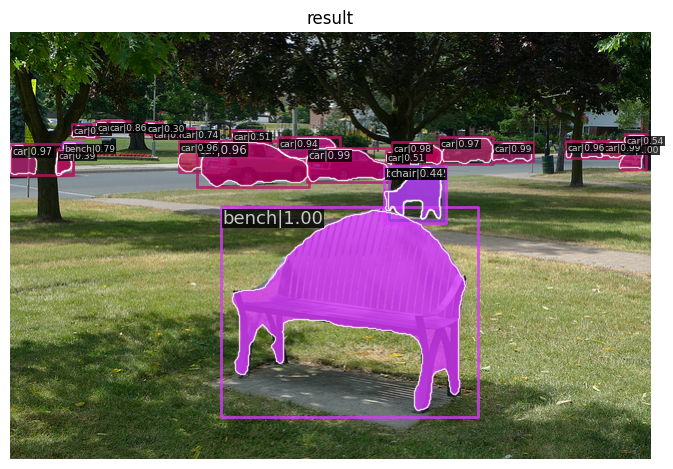

In [6]:
from mmdet.apis import show_result_pyplot

show_result_pyplot(model, img, result)

## Process - Train
0. 필요한 라이브러리 설치
1. 학습데이터 살펴보기
2. 필요한 패키지 import 및 환경 설정
3. COCO 데이터셋 다운로드 및 경로 설정
4. Mask R-CNN용 Config 설정
5. Config 객체 생성 및 데이터셋 빌드
6. 모델 및 학습 설정
7. 학습된 모델로 인스턴스 세그멘테이션 예측하기
8. Mask RCNN 모델 살펴보기

### 0. 필요한 라이브러리 설치

```
# install pytorch
!pip install torch==1.7.0+cu110 torchvision==0.8.1+cu110 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Step 0. Install MMCV using MIM.
!pip install openmim
!mim install mmcv-full

# Step 1. Install MMDetection.
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection
!pip install -v -e .
```

### 1. 학습데이터 살펴보기

- 먼저 필요한 라이브러리를 설치하고 불러오겠습니다.
    ```
    !pip install pycocotools
    ```

In [9]:
import os
import json
import random
from pathlib import Path
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 다음으로, COCO 데이터셋에 대한 경로와 사용할 이미지 개수를 설정합니다.
data_root = Path("dataset/")
val_ann_path = data_root / "annotations/instances_val2017_filtered_person.json"
val_img_dir = data_root / "val2017"

num_images_to_display = 5  # 시각화할 이미지의 수를 설정합니다.

# COCO 데이터셋을 로드하고 이미지 목록을 가져옵니다.
coco = COCO(str(val_ann_path))
image_ids = coco.getImgIds()

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


coco dataset에서 특정 class만 parsing 하는법
- https://github.com/kimnamu/annotation/blob/main/coco/create_subclass.ipynb

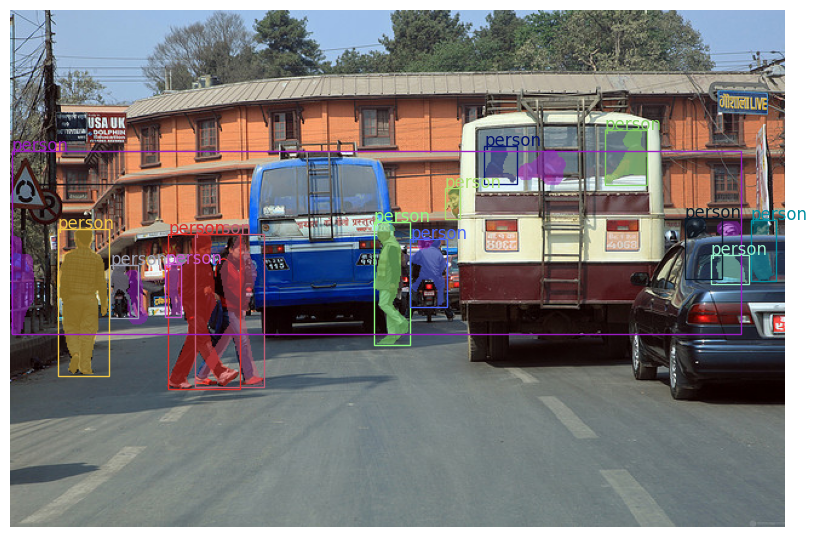

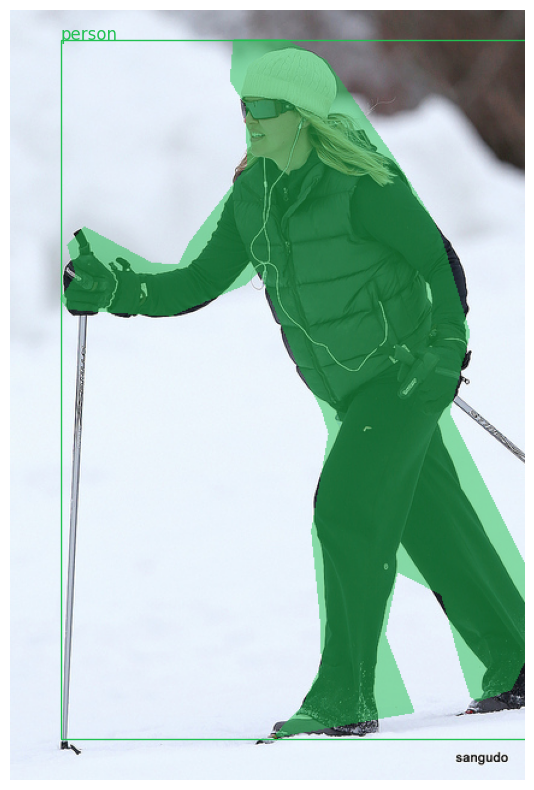

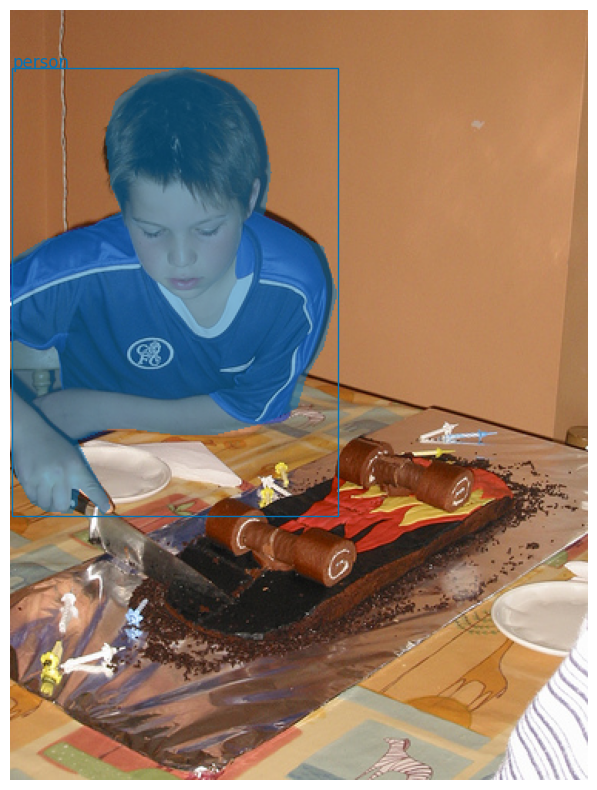

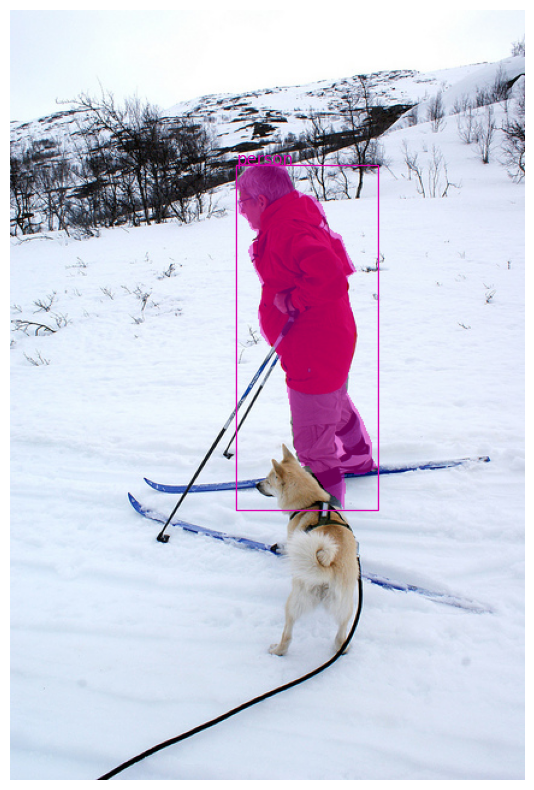

In [10]:
# 이 코드를 실행하면 annotations/instances_val2017.json 파일의 좌표 정보를 사용하여 COCO 데이터셋에서 무작위로 선택된 이미지들에 대해 인스턴스 세그멘테이션 결과를 시각화합니다.
# 시각화된 이미지에는 각 객체에 대한 바운딩 박스와 클래스 이름이 표시되며, 객체의 영역은 반투명한 색상으로 표현됩니다.
def apply_mask(image, mask, color, alpha=0.5):
    """이미지에 Mask를 적용합니다."""
    for c in range(3):
        image[:, :, c] = np.where(
            mask == 1,
            image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
            image[:, :, c]
        )
    return image

def random_color():
    """무작위로 색상을 생성합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    return tuple(np.random.random(size=3))

def draw_bbox(ax, bbox, color, class_name):
    """이미지에 바운딩 박스와 클래스 이름을 그립니다."""
    x, y, width, height = bbox
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, class_name, color=color, fontsize=12, bbox=dict(facecolor='none', edgecolor='none', alpha=0.5, pad=0))


data_root = Path("dataset/")
val_ann_path = data_root / "annotations/instances_val2017_filtered_person.json"
val_img_dir = data_root / "val2017"

selected_image_ids = random.sample(image_ids, num_images_to_display)

for image_id in selected_image_ids:
    image_data = coco.loadImgs(image_id)[0]
    image_path = val_img_dir / image_data['file_name']
    image = Image.open(image_path)
    image = np.array(image)
    
    ann_ids = coco.getAnnIds(imgIds=image_data['id'])
    annotations = coco.loadAnns(ann_ids)

    fig, ax = plt.subplots(figsize=(10, 10))
    
    for ann in annotations:
        if 'segmentation' not in ann:
            continue

        category_id = ann['category_id']
        cat = coco.loadCats(category_id)[0]['name']
        
        # Segmentation Mask를 얻습니다.
        mask = coco.annToMask(ann)
        
        # 무작위 색상을 선택하고 Mask를 이미지에 적용합니다.
        color = random_color()
        image = apply_mask(image, mask, color)

        # 바운딩 박스와 클래스 이름을 그립니다.
        draw_bbox(ax, ann['bbox'], color, cat)

    # Mask와 바운딩 박스가 적용된 이미지를 시각화합니다.
    ax.imshow(image)
    ax.axis("off")
    plt.show()


### 2. 필요한 패키지 import 및 환경 설정

In [11]:
import os
import sys
from mmcv import Config
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector, init_detector, inference_detector, show_result_pyplot
from mmdet.datasets import CocoDataset

### 3. COCO 데이터셋 다운로드 및 경로 설정
데이터셋을 다운로드 받으려면 아래 코드의 주석을 풀어주고 알맞은 경로에 저장하세요.

In [12]:
# !wget http://images.cocodataset.org/zips/train2017.zip
# !wget http://images.cocodataset.org/zips/val2017.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# !unzip -q train2017.zip -d data/coco/
# !unzip -q val2017.zip -d data/coco/
# !unzip -q annotations_trainval2017.zip -d data/coco/annotations/

### 4. Swin Transformer용 Config 설정

In [6]:
config_dataset = """
# dataset settings
dataset_type = 'CocoDataset'
data_root = 'dataset/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

custom_classes = ['person']                                         # 여기에 사용자 지정 클래스를 입력하세요.

data = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    train=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations/instances_val2017_filtered_person.json',  # 'annotations/instances_train2017.json'
        img_prefix=data_root + 'val2017/',                          # 'train2017/'
        pipeline=train_pipeline,
        classes=custom_classes),                                    # 데이터셋 설정에 사용자 지정 클래스를 추가합니다.
    val=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations/instances_val2017_filtered_person.json',
        img_prefix=data_root + 'val2017/',
        pipeline=test_pipeline,
        classes=custom_classes),                                    # 데이터셋 설정에 사용자 지정 클래스를 추가합니다.
    test=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations/instances_val2017_filtered_person.json',
        img_prefix=data_root + 'val2017/',
        pipeline=test_pipeline,
        classes=custom_classes))                                   # 데이터셋 설정에 사용자 지정 클래스를 추가합니다.
evaluation = dict(metric=['bbox'])                                  # 'bbox' is for object detection, 'segm' is for mask detection
"""

with open("configs/_base_/datasets/coco_sample.py", 'w') as f:
    f.write(config_dataset)

config_model='''
_base_ = [
    '../_base_/models/mask_rcnn_r50_fpn.py',
    '../_base_/datasets/coco_sample.py',
    '../_base_/schedules/schedule_1x.py',
    '../_base_/default_runtime.py'
]
pretrained = 'https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth'  # noqa
model = dict(
    type='MaskRCNN',
    backbone=dict(
        _delete_=True,
        type='SwinTransformer',
        embed_dims=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        mlp_ratio=4,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.,
        attn_drop_rate=0.,
        drop_path_rate=0.2,
        patch_norm=True,
        out_indices=(0, 1, 2, 3),
        with_cp=False,
        convert_weights=True,
        init_cfg=dict(type='Pretrained', checkpoint=pretrained)),
    neck=dict(in_channels=[96, 192, 384, 768]))

optimizer = dict(
    _delete_=True,
    type='AdamW',
    lr=0.0001,
    betas=(0.9, 0.999),
    weight_decay=0.05,
    paramwise_cfg=dict(
        custom_keys={
            'absolute_pos_embed': dict(decay_mult=0.),
            'relative_position_bias_table': dict(decay_mult=0.),
            'norm': dict(decay_mult=0.)
        }))
lr_config = dict(warmup_iters=1000, step=[8, 11])
runner = dict(max_epochs=10)                                                        # 학습 epoch 결정
'''

with open('configs/swin/mask_rcnn_swin-t-p4-w7_fpn_1x_coco_sample.py', 'w') as f:
    f.write(config_model)

### 5. Config 객체 생성 및 데이터셋 빌드

In [15]:
import os
config = './configs/swin/mask_rcnn_swin-t-p4-w7_fpn_1x_coco_sample.py'
cfg = Config.fromfile(config)

cfg.model.roi_head.bbox_head.num_classes=1
cfg.model.roi_head.mask_head.num_classes=1

print(cfg.data.train)
datasets = [build_dataset(cfg.data.train)]

{'type': 'CocoDataset', 'ann_file': 'dataset/annotations/instances_val2017_filtered_person.json', 'img_prefix': 'dataset/val2017/', 'pipeline': [{'type': 'LoadImageFromFile'}, {'type': 'LoadAnnotations', 'with_bbox': True, 'with_mask': True}, {'type': 'Resize', 'img_scale': (1333, 800), 'keep_ratio': True}, {'type': 'RandomFlip', 'flip_ratio': 0.5}, {'type': 'Normalize', 'mean': [123.675, 116.28, 103.53], 'std': [58.395, 57.12, 57.375], 'to_rgb': True}, {'type': 'Pad', 'size_divisor': 32}, {'type': 'DefaultFormatBundle'}, {'type': 'Collect', 'keys': ['img', 'gt_bboxes', 'gt_labels', 'gt_masks']}], 'classes': ['person']}
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


### 6. 모델 및 학습 설정

In [16]:
from mmdet.apis import set_random_seed

model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.init_weights()

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.device = 'cuda'
cfg.gpu_ids = range(1)
cfg.work_dir = './swin_object_detection'
cfg.runner.max_epochs = 10

train_detector(model, datasets, cfg, distributed=False, validate=True)


2023-04-10 22:46:32,088 - mmdet - INFO - load checkpoint from http path: https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth
2023-04-10 22:46:32,182 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2023-04-10 22:46:32,199 - mmcv - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2023-04-10 22:46:32,207 - mmcv - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std': 0.001, 'override': {'name': 'fc_reg'}}, {'type': 'Xavier', 'distribution': 'uniform', 'override': [{'name': 'shared_fcs'}, {'name': 'cls_fcs'}, {'name': 'reg_fcs'}]}]
2023-04-10 22:46:32,374 - mmcv - INFO - 
backbone.patch_embed.projection.weight - torch.Size([96, 3, 4, 4]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2023-04-10 22:46:32,375 - mmcv - INFO - 
backbone.

loading annotations into memory...


2023-04-10 22:46:32,991 - mmdet - INFO - Start running, host: ohouse-recomm@ohouse-recomm, work_dir: /home/ohouse-recomm/lucas/models/mmdetection/swin_object_detection
2023-04-10 22:46:32,991 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
 -------------------- 
after_train_

Done (t=0.36s)
creating index...
index created!


2023-04-10 22:47:03,348 - mmdet - INFO - Epoch [1][50/1347]	lr: 4.995e-06, eta: 2:43:00, time: 0.607, data_time: 0.058, memory: 7331, loss_rpn_cls: 0.6644, loss_rpn_bbox: 0.0460, loss_cls: 0.3132, acc: 87.3457, loss_bbox: 0.0047, loss_mask: 5.0821, loss: 6.1104
2023-04-10 22:47:32,487 - mmdet - INFO - Epoch [1][100/1347]	lr: 9.990e-06, eta: 2:39:16, time: 0.583, data_time: 0.015, memory: 7331, loss_rpn_cls: 0.5307, loss_rpn_bbox: 0.0440, loss_cls: 0.0885, acc: 98.1992, loss_bbox: 0.0460, loss_mask: 2.4766, loss: 3.1859
2023-04-10 22:48:01,983 - mmdet - INFO - Epoch [1][150/1347]	lr: 1.499e-05, eta: 2:38:19, time: 0.590, data_time: 0.015, memory: 7332, loss_rpn_cls: 0.3365, loss_rpn_bbox: 0.0510, loss_cls: 0.0904, acc: 97.9062, loss_bbox: 0.0602, loss_mask: 1.7586, loss: 2.2968
2023-04-10 22:48:31,208 - mmdet - INFO - Epoch [1][200/1347]	lr: 1.998e-05, eta: 2:37:15, time: 0.584, data_time: 0.014, memory: 7332, loss_rpn_cls: 0.2073, loss_rpn_bbox: 0.0442, loss_cls: 0.1034, acc: 97.3047, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2693/2693, 7.3 task/s, elapsed: 370s, ETA:     0s

2023-04-10 23:06:19,266 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.36s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.15s).
Accumulating evaluation results...


2023-04-10 23:06:40,981 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.471
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.059
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.226
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.208
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.261
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.55s).


2023-04-10 23:07:13,410 - mmdet - INFO - Epoch [2][50/1347]	lr: 1.000e-04, eta: 2:23:22, time: 0.647, data_time: 0.060, memory: 7799, loss_rpn_cls: 0.0480, loss_rpn_bbox: 0.0460, loss_cls: 0.2008, acc: 92.3867, loss_bbox: 0.2799, loss_mask: 0.4295, loss: 1.0042
2023-04-10 23:07:43,515 - mmdet - INFO - Epoch [2][100/1347]	lr: 1.000e-04, eta: 2:23:03, time: 0.602, data_time: 0.014, memory: 7799, loss_rpn_cls: 0.0333, loss_rpn_bbox: 0.0431, loss_cls: 0.1745, acc: 93.2363, loss_bbox: 0.2427, loss_mask: 0.4247, loss: 0.9181
2023-04-10 23:08:13,625 - mmdet - INFO - Epoch [2][150/1347]	lr: 1.000e-04, eta: 2:22:43, time: 0.602, data_time: 0.014, memory: 7799, loss_rpn_cls: 0.0395, loss_rpn_bbox: 0.0372, loss_cls: 0.1692, acc: 93.7891, loss_bbox: 0.2339, loss_mask: 0.4382, loss: 0.9181
2023-04-10 23:08:44,463 - mmdet - INFO - Epoch [2][200/1347]	lr: 1.000e-04, eta: 2:22:30, time: 0.617, data_time: 0.015, memory: 7799, loss_rpn_cls: 0.0387, loss_rpn_bbox: 0.0390, loss_cls: 0.1883, acc: 93.0547, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2693/2693, 7.4 task/s, elapsed: 362s, ETA:     0s

2023-04-10 23:26:29,297 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.40s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.72s).
Accumulating evaluation results...


2023-04-10 23:26:49,106 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.613
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.172
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.31s).


2023-04-10 23:27:21,870 - mmdet - INFO - Epoch [3][50/1347]	lr: 1.000e-04, eta: 2:10:54, time: 0.653, data_time: 0.059, memory: 7834, loss_rpn_cls: 0.0343, loss_rpn_bbox: 0.0402, loss_cls: 0.1737, acc: 93.5000, loss_bbox: 0.2362, loss_mask: 0.3665, loss: 0.8509
2023-04-10 23:27:52,372 - mmdet - INFO - Epoch [3][100/1347]	lr: 1.000e-04, eta: 2:10:31, time: 0.610, data_time: 0.015, memory: 7834, loss_rpn_cls: 0.0373, loss_rpn_bbox: 0.0382, loss_cls: 0.1673, acc: 93.6406, loss_bbox: 0.2417, loss_mask: 0.3541, loss: 0.8385
2023-04-10 23:28:23,061 - mmdet - INFO - Epoch [3][150/1347]	lr: 1.000e-04, eta: 2:10:08, time: 0.614, data_time: 0.016, memory: 7834, loss_rpn_cls: 0.0304, loss_rpn_bbox: 0.0369, loss_cls: 0.1891, acc: 92.4297, loss_bbox: 0.2857, loss_mask: 0.3829, loss: 0.9250
2023-04-10 23:28:54,235 - mmdet - INFO - Epoch [3][200/1347]	lr: 1.000e-04, eta: 2:09:47, time: 0.623, data_time: 0.018, memory: 7834, loss_rpn_cls: 0.0257, loss_rpn_bbox: 0.0367, loss_cls: 0.1772, acc: 92.9492, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2693/2693, 8.1 task/s, elapsed: 334s, ETA:     0s

2023-04-10 23:46:14,927 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=12.02s).
Accumulating evaluation results...


2023-04-10 23:46:28,872 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.690
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.428
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.507
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.42s).


2023-04-10 23:47:01,466 - mmdet - INFO - Epoch [4][50/1347]	lr: 1.000e-04, eta: 1:58:18, time: 0.650, data_time: 0.058, memory: 7834, loss_rpn_cls: 0.0231, loss_rpn_bbox: 0.0377, loss_cls: 0.1649, acc: 93.3535, loss_bbox: 0.2509, loss_mask: 0.3379, loss: 0.8145
2023-04-10 23:47:31,844 - mmdet - INFO - Epoch [4][100/1347]	lr: 1.000e-04, eta: 1:57:51, time: 0.608, data_time: 0.015, memory: 7834, loss_rpn_cls: 0.0271, loss_rpn_bbox: 0.0382, loss_cls: 0.1702, acc: 93.2129, loss_bbox: 0.2401, loss_mask: 0.3446, loss: 0.8203
2023-04-10 23:48:02,298 - mmdet - INFO - Epoch [4][150/1347]	lr: 1.000e-04, eta: 1:57:25, time: 0.609, data_time: 0.016, memory: 7834, loss_rpn_cls: 0.0275, loss_rpn_bbox: 0.0413, loss_cls: 0.1738, acc: 92.8926, loss_bbox: 0.2724, loss_mask: 0.3636, loss: 0.8785
2023-04-10 23:48:33,024 - mmdet - INFO - Epoch [4][200/1347]	lr: 1.000e-04, eta: 1:56:59, time: 0.615, data_time: 0.016, memory: 7834, loss_rpn_cls: 0.0262, loss_rpn_bbox: 0.0349, loss_cls: 0.1834, acc: 92.5215, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2693/2693, 8.4 task/s, elapsed: 322s, ETA:     0s

2023-04-11 00:05:39,327 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.26s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.69s).
Accumulating evaluation results...


2023-04-11 00:05:50,415 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.752
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.357
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.460
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.499
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.384
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.557
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.99s).


2023-04-11 00:06:23,369 - mmdet - INFO - Epoch [5][50/1347]	lr: 1.000e-04, eta: 1:45:16, time: 0.658, data_time: 0.061, memory: 7856, loss_rpn_cls: 0.0244, loss_rpn_bbox: 0.0339, loss_cls: 0.1693, acc: 93.2109, loss_bbox: 0.2584, loss_mask: 0.3321, loss: 0.8181
2023-04-11 00:06:54,029 - mmdet - INFO - Epoch [5][100/1347]	lr: 1.000e-04, eta: 1:44:49, time: 0.613, data_time: 0.014, memory: 7856, loss_rpn_cls: 0.0201, loss_rpn_bbox: 0.0347, loss_cls: 0.1667, acc: 93.0723, loss_bbox: 0.2552, loss_mask: 0.3287, loss: 0.8054
2023-04-11 00:07:24,761 - mmdet - INFO - Epoch [5][150/1347]	lr: 1.000e-04, eta: 1:44:22, time: 0.615, data_time: 0.015, memory: 7856, loss_rpn_cls: 0.0189, loss_rpn_bbox: 0.0331, loss_cls: 0.1608, acc: 93.3945, loss_bbox: 0.2524, loss_mask: 0.3383, loss: 0.8036
2023-04-11 00:07:55,558 - mmdet - INFO - Epoch [5][200/1347]	lr: 1.000e-04, eta: 1:43:55, time: 0.616, data_time: 0.014, memory: 7856, loss_rpn_cls: 0.0347, loss_rpn_bbox: 0.0367, loss_cls: 0.1551, acc: 93.7090, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2693/2693, 8.2 task/s, elapsed: 330s, ETA:     0s

2023-04-11 00:25:10,417 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.33s).
Accumulating evaluation results...


2023-04-11 00:25:23,812 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.414
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.771
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.404
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.526
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.534
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.534
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.534
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.423
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.584
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.56s).


2023-04-11 00:25:56,637 - mmdet - INFO - Epoch [6][50/1347]	lr: 1.000e-04, eta: 1:32:08, time: 0.655, data_time: 0.060, memory: 7861, loss_rpn_cls: 0.0182, loss_rpn_bbox: 0.0265, loss_cls: 0.1446, acc: 94.1445, loss_bbox: 0.2250, loss_mask: 0.3026, loss: 0.7170
2023-04-11 00:26:27,040 - mmdet - INFO - Epoch [6][100/1347]	lr: 1.000e-04, eta: 1:31:40, time: 0.608, data_time: 0.015, memory: 7861, loss_rpn_cls: 0.0210, loss_rpn_bbox: 0.0335, loss_cls: 0.1501, acc: 94.2051, loss_bbox: 0.2276, loss_mask: 0.3182, loss: 0.7504
2023-04-11 00:26:57,612 - mmdet - INFO - Epoch [6][150/1347]	lr: 1.000e-04, eta: 1:31:12, time: 0.611, data_time: 0.014, memory: 7861, loss_rpn_cls: 0.0227, loss_rpn_bbox: 0.0310, loss_cls: 0.1527, acc: 93.8672, loss_bbox: 0.2214, loss_mask: 0.3155, loss: 0.7432
2023-04-11 00:27:28,535 - mmdet - INFO - Epoch [6][200/1347]	lr: 1.000e-04, eta: 1:30:44, time: 0.618, data_time: 0.017, memory: 7861, loss_rpn_cls: 0.0210, loss_rpn_bbox: 0.0327, loss_cls: 0.1584, acc: 93.4570, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2693/2693, 7.7 task/s, elapsed: 350s, ETA:     0s

2023-04-11 00:45:06,898 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.35s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=14.76s).
Accumulating evaluation results...


2023-04-11 00:45:24,390 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.797
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.482
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.555
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.421
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.597
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.89s).


2023-04-11 00:45:57,631 - mmdet - INFO - Epoch [7][50/1347]	lr: 1.000e-04, eta: 1:19:00, time: 0.663, data_time: 0.062, memory: 7861, loss_rpn_cls: 0.0251, loss_rpn_bbox: 0.0356, loss_cls: 0.1560, acc: 93.8535, loss_bbox: 0.2479, loss_mask: 0.3158, loss: 0.7806
2023-04-11 00:46:27,894 - mmdet - INFO - Epoch [7][100/1347]	lr: 1.000e-04, eta: 1:18:31, time: 0.605, data_time: 0.015, memory: 7861, loss_rpn_cls: 0.0160, loss_rpn_bbox: 0.0355, loss_cls: 0.1271, acc: 94.6934, loss_bbox: 0.2029, loss_mask: 0.2738, loss: 0.6553
2023-04-11 00:46:58,622 - mmdet - INFO - Epoch [7][150/1347]	lr: 1.000e-04, eta: 1:18:03, time: 0.615, data_time: 0.015, memory: 7861, loss_rpn_cls: 0.0180, loss_rpn_bbox: 0.0329, loss_cls: 0.1542, acc: 93.7988, loss_bbox: 0.2356, loss_mask: 0.3207, loss: 0.7614
2023-04-11 00:47:29,435 - mmdet - INFO - Epoch [7][200/1347]	lr: 1.000e-04, eta: 1:17:34, time: 0.616, data_time: 0.015, memory: 7861, loss_rpn_cls: 0.0139, loss_rpn_bbox: 0.0317, loss_cls: 0.1334, acc: 94.4883, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2693/2693, 8.4 task/s, elapsed: 322s, ETA:     0s

2023-04-11 01:04:38,232 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.16s).
Accumulating evaluation results...


2023-04-11 01:04:48,826 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.469
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.812
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.502
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.369
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.548
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.581
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.571
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.571
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.571
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.453
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.03s).


2023-04-11 01:05:21,356 - mmdet - INFO - Epoch [8][50/1347]	lr: 1.000e-04, eta: 1:05:48, time: 0.649, data_time: 0.059, memory: 7861, loss_rpn_cls: 0.0150, loss_rpn_bbox: 0.0240, loss_cls: 0.1150, acc: 95.4102, loss_bbox: 0.1777, loss_mask: 0.2533, loss: 0.5851
2023-04-11 01:05:51,864 - mmdet - INFO - Epoch [8][100/1347]	lr: 1.000e-04, eta: 1:05:19, time: 0.610, data_time: 0.016, memory: 7861, loss_rpn_cls: 0.0191, loss_rpn_bbox: 0.0334, loss_cls: 0.1410, acc: 94.2266, loss_bbox: 0.2189, loss_mask: 0.3058, loss: 0.7182
2023-04-11 01:06:22,935 - mmdet - INFO - Epoch [8][150/1347]	lr: 1.000e-04, eta: 1:04:51, time: 0.621, data_time: 0.017, memory: 7861, loss_rpn_cls: 0.0211, loss_rpn_bbox: 0.0379, loss_cls: 0.1506, acc: 93.8105, loss_bbox: 0.2393, loss_mask: 0.3333, loss: 0.7822
2023-04-11 01:06:54,660 - mmdet - INFO - Epoch [8][200/1347]	lr: 1.000e-04, eta: 1:04:23, time: 0.634, data_time: 0.018, memory: 7861, loss_rpn_cls: 0.0147, loss_rpn_bbox: 0.0329, loss_cls: 0.1449, acc: 93.8359, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2693/2693, 8.3 task/s, elapsed: 326s, ETA:     0s

2023-04-11 01:24:08,340 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.69s).
Accumulating evaluation results...


2023-04-11 01:24:20,587 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.871
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.544
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.580
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.616
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.592
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.592
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.592
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.466
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.11s).


2023-04-11 01:24:53,611 - mmdet - INFO - Epoch [9][50/1347]	lr: 1.000e-05, eta: 0:52:35, time: 0.659, data_time: 0.062, memory: 7861, loss_rpn_cls: 0.0165, loss_rpn_bbox: 0.0285, loss_cls: 0.1348, acc: 94.3672, loss_bbox: 0.2238, loss_mask: 0.2599, loss: 0.6635
2023-04-11 01:25:23,870 - mmdet - INFO - Epoch [9][100/1347]	lr: 1.000e-05, eta: 0:52:06, time: 0.605, data_time: 0.013, memory: 7861, loss_rpn_cls: 0.0129, loss_rpn_bbox: 0.0260, loss_cls: 0.1086, acc: 95.5234, loss_bbox: 0.1758, loss_mask: 0.2718, loss: 0.5951
2023-04-11 01:25:54,821 - mmdet - INFO - Epoch [9][150/1347]	lr: 1.000e-05, eta: 0:51:37, time: 0.619, data_time: 0.016, memory: 7861, loss_rpn_cls: 0.0126, loss_rpn_bbox: 0.0296, loss_cls: 0.1384, acc: 94.1641, loss_bbox: 0.2284, loss_mask: 0.2714, loss: 0.6804
2023-04-11 01:26:25,838 - mmdet - INFO - Epoch [9][200/1347]	lr: 1.000e-05, eta: 0:51:08, time: 0.620, data_time: 0.015, memory: 7861, loss_rpn_cls: 0.0126, loss_rpn_bbox: 0.0264, loss_cls: 0.1306, acc: 94.5918, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2693/2693, 8.5 task/s, elapsed: 315s, ETA:     0s

2023-04-11 01:43:32,577 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.63s).
Accumulating evaluation results...


2023-04-11 01:43:42,345 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.575
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.897
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.453
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.639
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.684
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.641
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.641
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.641
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.523
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.696
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.79s).


2023-04-11 01:44:15,606 - mmdet - INFO - Epoch [10][50/1347]	lr: 1.000e-05, eta: 0:39:22, time: 0.664, data_time: 0.060, memory: 7861, loss_rpn_cls: 0.0090, loss_rpn_bbox: 0.0215, loss_cls: 0.0955, acc: 96.0762, loss_bbox: 0.1701, loss_mask: 0.2204, loss: 0.5164
2023-04-11 01:44:46,998 - mmdet - INFO - Epoch [10][100/1347]	lr: 1.000e-05, eta: 0:38:53, time: 0.628, data_time: 0.017, memory: 7861, loss_rpn_cls: 0.0140, loss_rpn_bbox: 0.0293, loss_cls: 0.1307, acc: 94.4922, loss_bbox: 0.2183, loss_mask: 0.2624, loss: 0.6547
2023-04-11 01:45:17,636 - mmdet - INFO - Epoch [10][150/1347]	lr: 1.000e-05, eta: 0:38:23, time: 0.613, data_time: 0.015, memory: 7861, loss_rpn_cls: 0.0120, loss_rpn_bbox: 0.0241, loss_cls: 0.1129, acc: 95.0742, loss_bbox: 0.1993, loss_mask: 0.2526, loss: 0.6008
2023-04-11 01:45:48,137 - mmdet - INFO - Epoch [10][200/1347]	lr: 1.000e-05, eta: 0:37:54, time: 0.610, data_time: 0.015, memory: 7861, loss_rpn_cls: 0.0085, loss_rpn_bbox: 0.0199, loss_cls: 0.1099, acc: 95.34

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2693/2693, 8.6 task/s, elapsed: 313s, ETA:     0s

2023-04-11 02:02:51,540 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.11s).
Accumulating evaluation results...


2023-04-11 02:03:00,746 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.596
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.906
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.683
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.475
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.657
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.701
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.711
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.74s).


2023-04-11 02:03:33,983 - mmdet - INFO - Epoch [11][50/1347]	lr: 1.000e-05, eta: 0:26:06, time: 0.664, data_time: 0.059, memory: 7861, loss_rpn_cls: 0.0073, loss_rpn_bbox: 0.0221, loss_cls: 0.1014, acc: 95.6387, loss_bbox: 0.1813, loss_mask: 0.2416, loss: 0.5537


KeyboardInterrupt: 

이제 모델 학습이 시작됩니다. 학습 과정을 진행하며 생성되는 가중치 파일은 swin_object_detection/ 디렉토리에 저장됩니다.

### 7. 학습된 모델로 인스턴스 세그멘테이션 예측하기
학습이 완료되면, 학습된 모델의 가중치를 사용하여 인스턴스 세그멘테이션 결과를 얻을 수 있습니다.

load checkpoint from local path: swin_object_detection/epoch_10.pth


/home/ohouse-recomm/lucas/models/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


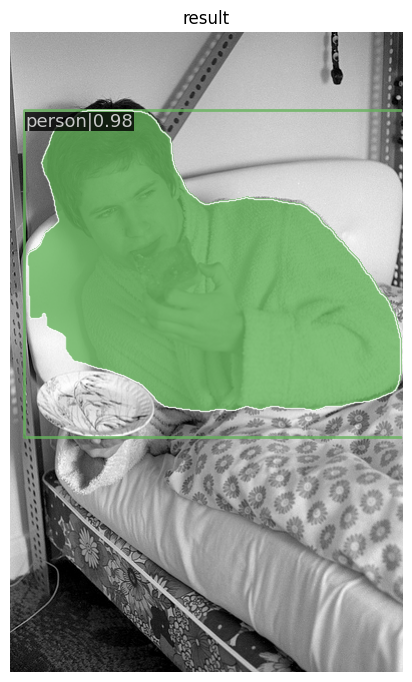

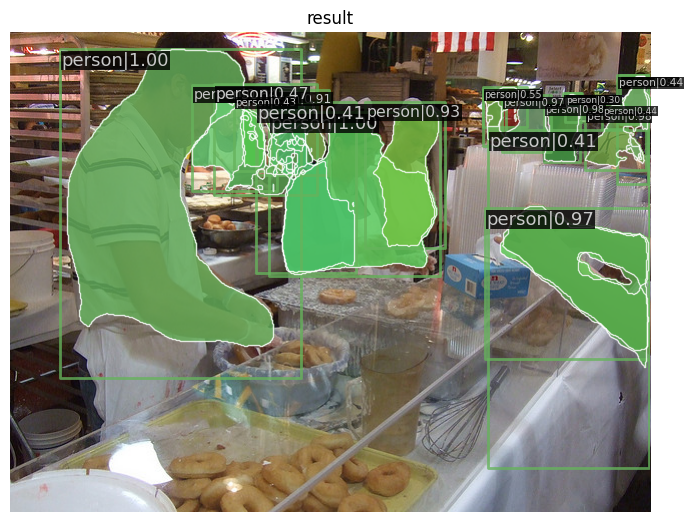

In [25]:
import os
import mmcv
from mmcv import Config
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from mmcv.runner import load_checkpoint

config = './configs/swin/mask_rcnn_swin-t-p4-w7_fpn_1x_coco_sample.py'
cfg = Config.fromfile(config)

cfg.model.roi_head.bbox_head.num_classes=1
cfg.model.roi_head.mask_head.num_classes=1
cfg.model.pretrained = None
checkpoint = 'swin_object_detection/epoch_10.pth'

model = init_detector(cfg, device='cuda:0')
checkpoint = load_checkpoint(model, checkpoint, map_location='cuda:0')

model.CLASSES = ["person"]
# print(checkpoint['meta']['CLASSES'])
img = 'dataset/val2017/000000254368.jpg'
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

img = 'dataset/val2017/000000450399.jpg'
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

- Threshold를 조절하여 다시 한번 visualization

load checkpoint from local path: swin_object_detection/epoch_10.pth


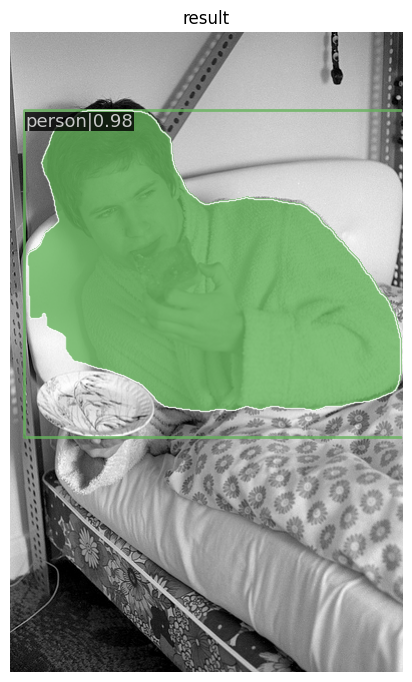

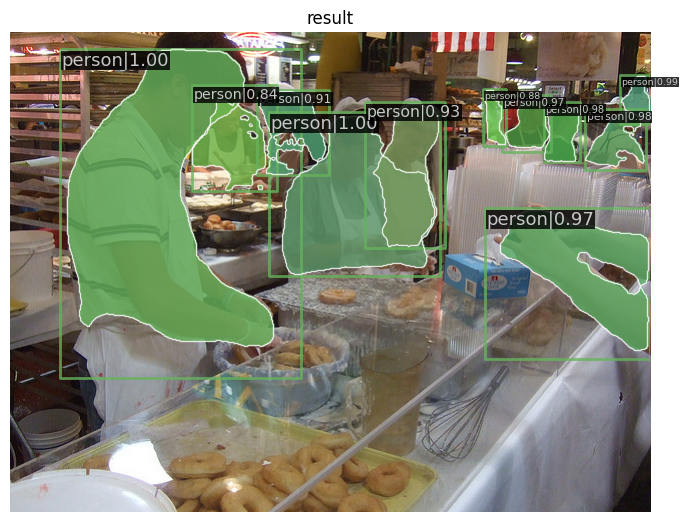

In [26]:
import os
import mmcv
from mmcv import Config
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from mmcv.runner import load_checkpoint

config = './configs/swin/mask_rcnn_swin-t-p4-w7_fpn_1x_coco_sample.py'
cfg = Config.fromfile(config)

cfg.model.roi_head.bbox_head.num_classes=1
cfg.model.roi_head.mask_head.num_classes=1
cfg.model.pretrained = None
checkpoint = 'swin_object_detection/epoch_10.pth'

model = init_detector(cfg, device='cuda:0')
checkpoint = load_checkpoint(model, checkpoint, map_location='cuda:0')

model.CLASSES = ["person"]
# print(checkpoint['meta']['CLASSES'])
img = 'dataset/val2017/000000254368.jpg'
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

img = 'dataset/val2017/000000450399.jpg'
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.7)

### 8. Swin Transformer 살펴보기

#### - Background?

- 컴퓨터 비전을 위한 트랜스포머가 필요한 이유?

컴퓨터 비전은 이미지 분류, 객체 감지 및 분할과 같은 다양한 비전 작업의 백본 네트워크 역할을 하기 위해 컨볼루션 레이어, 풀링 레이어 및 완전히 연결된 레이어와 같은 여러 빌딩 블록으로 구성된 CNN(Convolutional Neural Networks)이 주류를 이룹니다.

NLP(Natural Language Processing)의 경우 트랜스포머가 가장 일반적이고 널리 사용되는 아키텍처입니다. 트랜스포머는 번역 및 텍스트 요약을 위한 시퀀스 모델링 및 변환 작업을 위해 설계된 자체 주의 메커니즘을 사용합니다. 자체 주의력이 있는 변압기는 데이터의 장거리 의존성을 모델링하는 능력과 용이함으로 인해 엄청난 성공을 거두었습니다.

NLP에서 트랜스포머의 엄청난 성공으로 연구원들은 비전 트랜스포머를 시작으로 이제 시프트 윈도우 트랜스포머(SWIN Transformer)를 시작으로 컴퓨터 비전에서 트랜스포머의 사용법을 탐구하게 되었습니다.

<center><img src = "https://drive.google.com/uc?id=1L6Rmc4r1YodqTUh1As7ZyCZeh_ovgQ9F"  height = 300> </center>

- 언어에서 비전으로 트랜스포머를 적용할 때 어떤 어려움이 있나?

    언어에서 비전으로 트랜스포머를 적응시키는 데 어려움이 있는 것은 두 도메인 간의 차이 때문입니다.

    - 이미지는 시각적 실체의 규모에 큰 차이가 있지만 고정된 규모의 토큰이 있는 변압기 기반 모델입니다.
    - 텍스트 통로의 단어와 비교하여 이미지의 픽셀 해상도가 높습니다.
    - 자기 주의의 계산 복잡성은 이미지 크기에 대한 2차적입니다

#### - Swin Transformer

Swin Transforemr 논문에서는 컴퓨터 비전을 위한 범용 백본 역할을 할 수 있는 스윈 트랜스포머라는 새로운 비전 트랜스포머를 제시합니다. 트랜스포머를 언어에서 시각으로 적응시키는 데 어려움이 있는 것은 시각적 실체의 규모의 큰 변화와 텍스트의 단어와 비교하여 이미지의 픽셀의 높은 해상도와 같은 두 도메인 간의 차이에서 발생합니다. 이러한 차이를 해결하기 위해 Shift 창으로 표현이 계산되는 계층적 변압기를 제안합니다. 전환된 윈도우 설정 체계는 자체 주의 계산을 중복되지 않는 로컬 윈도우로 제한하는 동시에 교차 윈도우 연결을 허용함으로써 효율성을 높입니다. 이 계층 구조는 다양한 규모로 모델링할 수 있는 유연성을 가지고 있으며 이미지 크기와 관련된 선형 계산 복잡성을 가지고 있습니다. Swin Transformer의 이러한 품질은 이미지 분류(ImageNet-1K에서 87.3 상위 1 정확도) 및 객체 감지(COCO 테스트 개발에서 58.7 박스 AP 및 51.1 마스크 AP) 및 의미 분할(ADE20K 밸브에서 53.5 MioU)과 같은 밀도 높은 예측 작업을 포함한 광범위한 비전 작업과 호환됩니다. COCO에서는 +2.7 박스 AP와 +2.6 마스크 AP, ADE20K에서는 +3.2mIoU의 큰 차이로 이전의 최첨단 성능을 능가하여 비전 백본으로서 트랜스포머 기반 모델의 잠재력을 보여줍니다. 계층적 설계와 전환된 창 접근 방식은 또한 모든 MLP 아키텍처에 유용합니다. 코드 및 모델은 https://github.com/Microsoft/Swin-Transformer 에서 공개적으로 제공됩니다.

<center><img src = "https://drive.google.com/uc?id=13onfjpqJZWotvD2U2jR9DX9DGCJh6PWR"  height = 300> </center>
위 이미지는 제안된 Swin Transformer² 아키텍처에서 자체 주의 계산을 위한 전환된 창 접근 방식을 보여줍니다. 왼쪽 이미지 - 레이어 l에서 일반 창 분할 체계가 채택되고 각 창 내에서 자체 주의가 계산됩니다. 다음 계층 l+1(오른쪽 이미지)에서 창 분할이 이동되어 새 창이 생성됩니다. 새 창의 자체 주의 계산은 레이어 l에서 이전 창의 경계를 통과하여 그들 사이의 연결을 제공합니다.


<center><img src = "https://drive.google.com/uc?id=17uvc26wiS8JbYXlGg98HGDGF2ORPm2P5"  height = 300> </center>

Swin Transformer² 아키텍처는 4단계로 수행됩니다. 기본적으로 패치 파티션(패치 파티션 전략: 왼쪽 위 픽셀에서 시작하여 8x8 형상 맵이 4x4 크기의 2x2 창으로 고르게 분할됩니다(M=4). 그런 다음 RGB 입력 이미지를 겹치지 않는 패치로 분할하는 데 적용됩니다. 특히, 이미지를 토큰으로 처리되는 2개의 4x4 패치로 분할합니다. 또한 모든 패치에는 3개의 채널이 있으므로 4x4x3=48개의 항목 또는 기능 차원이 있습니다.

그런 다음 선형 임베딩(변환) 레이어가 이 원시 값 피쳐에 적용되어 선택한 차원 C에 투영되며, 이는 변압기 ¹ 모델의 용량/크기도 결정합니다. 그 옆에 여러 Swin Transformer² 블록이 이러한 패치에 적용되었으며 토큰 수(H/4 x W/4)도 유지됩니다. 선형 임베딩이 있는 Swin Transformer 블록은 첫 번째 단계로 구성됩니다.

네트워크가 깊어지면 토큰은 패치 병합 계층에 의해 감소하고 계층적 표현을 생성하는 데 기여합니다. 첫 번째 패치 병합 계층에서는 각 그룹의 기능이 2x2개의 인접 패치로 연결된 다음 4C 차원 연결된 기능에 선형 계층을 적용합니다. 따라서 토큰 수는 2x2=4(2 Down sample of resolution)의 배수로 줄어들고 출력 치수는 2C로 설정됩니다.

다음으로 분해능을 (H/8 X W/8)로 유지하여 형상 변환을 위해 여러 Swin Transformer 블록을 적용합니다. 패치 병합 레이어와 변압기 블록은 2단계로 표시됩니다.

마찬가지로 3단계와 4단계에서는 형상 변환을 위해 변압기 블록과 결합된 패치 병합 레이어에 각각 출력 해상도(H/16 X W/16)와 (H/32 X W/32)가 적용됩니다.

Swin Transformer는 Transformer 블록의 표준 MSA(Multi-head Self-attention) 모듈을 다른 레이어는 동일하게 유지하면서 시프트된 윈도우 기반 모듈로 교체하여 구축되었습니다.

<center><img src = "https://drive.google.com/uc?id=18IykLAAkJKLzQWT7gb6U7hqLBgxxG-QD"  height = 300> </center>
위 그림에 표시된 것처럼 Swin Transformer 블록은 시프트된 창 기반 MSA 모듈과 그 사이에 GELU 비선형성이 있는 2층 MLP로 구성됩니다. 각 MSA 모듈 및 각 MLP 이전에는 LN(Layer Norm) 계층이 적용되고, 각 모듈 이후에는 잔여 연결이 적용됩니다.


- Reference: https://arshren.medium.com/swin-transformer-a-unifying-step-between-computer-vision-and-natural-language-processing-3fc0e59ff8f2